In [13]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [78]:
kp_training_df = pd.read_csv('../../KPA_2021_shared_task/kpm_data/key_points_train.csv')
arg_training_df = pd.read_csv('../../KPA_2021_shared_task/kpm_data/arguments_train.csv')
labels_training_df = pd.read_csv('../../KPA_2021_shared_task/kpm_data/labels_train.csv')

In [7]:
kp_training_df.head()

,key_point_id,key_point,topic,stance
0,kp_0_0,Assisted suicide gives dignity to the person t...,Assisted suicide should be a criminal offence,-1
1,kp_0_1,Assisted suicide reduces suffering,Assisted suicide should be a criminal offence,-1
2,kp_0_2,People should have the freedom to choose to en...,Assisted suicide should be a criminal offence,-1
3,kp_0_3,The terminally ill would benefit from assisted...,Assisted suicide should be a criminal offence,-1
4,kp_0_4,Assisted suicide allows people to solicit some...,Assisted suicide should be a criminal offence,1


In [79]:
labels_training_df.head()

,arg_id,key_point_id,label
0,arg_0_0,kp_0_0,0
1,arg_0_121,kp_0_4,0
2,arg_0_121,kp_0_5,0
3,arg_0_121,kp_0_6,1
4,arg_0_121,kp_0_7,0


In [74]:
arg_training_df.head()

,arg_id,argument,topic,stance
0,arg_0_0,`people reach their limit when it comes to the...,Assisted suicide should be a criminal offence,-1
1,arg_0_1,A patient should be able to decide when they h...,Assisted suicide should be a criminal offence,-1
2,arg_0_2,a person has the right to end their suffering ...,Assisted suicide should be a criminal offence,-1
3,arg_0_3,a person should have the dignity to choose how...,Assisted suicide should be a criminal offence,-1
4,arg_0_4,a person should have the right to be able to c...,Assisted suicide should be a criminal offence,-1


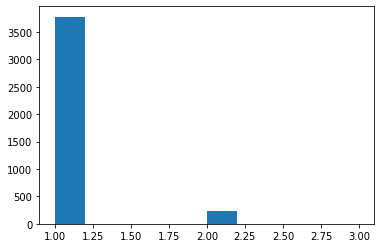

In [21]:
keypoints_per_arg = [x[1] for x in labels_training_df[labels_training_df.label == 1].arg_id.value_counts().to_dict().items()]
plt.hist(keypoints_per_arg)
plt.show()

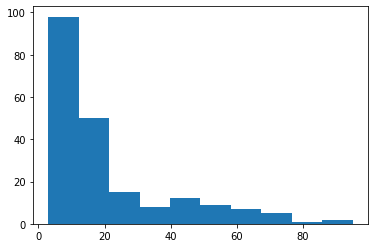

In [20]:
args_per_keypoints = [x[1] for x in labels_training_df[labels_training_df.label == 1].key_point_id.value_counts().to_dict().items()]
plt.hist(args_per_keypoints)
plt.show()

In [83]:
kp_valid_df = pd.read_csv('../../KPA_2021_shared_task/kpm_data/key_points_dev.csv')
arg_valid_df = pd.read_csv('../../KPA_2021_shared_task/kpm_data/arguments_dev.csv')
labels_valid_df = pd.read_csv('../../KPA_2021_shared_task/kpm_data/labels_our_valid.csv')

-------------

### Preparing data:

In [31]:
import random

In [93]:
def get_cand_neg(argument, key_points, pos_keypoints, count=3):
    #remove the matching keypoints
    cand_keypoints = [item[1] for item in key_points.items() if item[1] not in pos_keypoints]
    return random.sample(cand_keypoints, count)

def gen_triplet(arguments, keypoints, labels_df):
    triplets = []
    for arg_id, argument in arguments.items():
        neg_key_points = [row['keypoint'] for idx, row in labels_df[labels_df.arg_id == arg_id].iterrows() if row['label'] == 0]
        pos_key_points = [row['keypoint'] for idx, row in labels_df[labels_df.arg_id == arg_id].iterrows() if row['label'] == 1]
        if len(pos_key_points) == 0:
            #print('Skipping argument with no keypoints!')
            continue
        
                    
        #Add randomly sampled negative key-points
        cand_neg_key_points = get_cand_neg(argument, keypoints, pos_key_points)

        for pos_key_point in pos_key_points:
            
            #first add the gt negative key-point
            if len(neg_key_points) > 0:
                for neg_key_point in neg_key_points:
                    triplets.append([argument, pos_key_point, neg_key_point])
            
            #Add some negative examples
            for cand_neg_keypoint in cand_neg_key_points:
                triplets.append([argument, pos_key_point, cand_neg_keypoint ])

    return triplets

In [94]:
arguments = pd.Series(arg_training_df.argument.values, index=arg_training_df.arg_id).to_dict()
key_points= pd.Series(kp_training_df.key_point.values, index=kp_training_df.key_point_id).to_dict()

labels_training_df['argument'] = labels_training_df.arg_id.apply(lambda x: arguments[x])
labels_training_df['keypoint'] = labels_training_df.key_point_id.apply(lambda x: key_points[x])

train_triplets_data = gen_triplet(arguments, key_points, labels_training_df)

In [99]:
valid_arguments = pd.Series(arg_valid_df.argument.values, index=arg_valid_df.arg_id).to_dict()
valid_key_points= pd.Series(kp_valid_df.key_point.values, index=kp_valid_df.key_point_id).to_dict()

labels_valid_df['argument'] = labels_valid_df.arg_id.apply(lambda x: valid_arguments[x])
labels_valid_df['keypoint'] = labels_valid_df.key_point_id.apply(lambda x: valid_key_points[x])

valid_triplets_data = gen_triplet(valid_arguments, valid_key_points, labels_valid_df)

In [96]:
len(train_triplets_data)

25033

In [100]:
len(valid_triplets_data)

3066

In [102]:
training_triplet_df = pd.DataFrame(train_triplets_data, columns=['argument', 'pos_kp', 'neg_kp'])
valid_triplet_df = pd.DataFrame(valid_triplets_data, columns=['argument', 'pos_kp', 'neg_kp'])

In [103]:
training_triplet_df.to_csv('/workspace/ceph_data/keypoint-analysis-sharedtask/siamese-data/training_df.csv')
valid_triplet_df.to_csv('/workspace/ceph_data/keypoint-analysis-sharedtask/siamese-data/valid_df.csv')

----------

In [107]:
! CUDA_VISIBLE_DEVICES=1 python3 ../src-py/sbert_training.py

2021-05-04 16:54:05 - Use pytorch device: cuda
2021-05-04 16:54:05 - Read Triplet train dataset
2021-05-04 16:54:06 - Read Triplet dev dataset
Iteration:  64%|##################4          | 998/1565 [02:27<01:25,  6.67it/s]
                                                                                
2021-05-04 16:56:36 - TripletEvaluator: Evaluating the model on dev dataset in epoch 0 after 1000 steps:
Epoch:   0%|                                              | 0/3 [02:27<?, ?it/s]
                                                                                
2021-05-04 16:56:39 - Accuracy Cosine Distance:   	93.60                     
Epoch:   0%|                                              | 0/3 [02:30<?, ?it/s]
                                                                                
2021-05-04 16:56:39 - Accuracy Manhatten Distance:	93.30                     
Epoch:   0%|                                              | 0/3 [02:30<?, ?it/s]
                             